# Übung: Waldanteil berechnen

Nun sind wir so weit, dass wir 50 Simulation der Zeckenstiche mit zufällig verschobenen Punkten vorbereitet haben. Wir haben also die gleiche Ausgangslage, mit der ihr den Themenblock "Datenqualität und Unsicherheiten" gestartet habt. In der Todo-Liste sind wir nun bei Schritt 4: 


- Schritt 1: Einen Einzelpunkt zufällig verschieben ✓
- Schritt 2: Alle Punkte einer DataFrame zufällig verschieben (1 "Run") ✓
- Schritt 3: Alle Punkte einer DataFrame mehrfach zufällig verschieben (z.B. 50 "Runs") ✓
- **Schritt 4: Anteil der Punkte im Wald pro "Run" ermitteln**
  **1. Für jeden Simulierten Punkt zu bestimmen ob er innerhalb oder ausserhalb des Waldes liegt**
  **2. Den Anteil der Punkte im Wald pro Simulation zu bestimmen**

Lade dafür den Datensatz "wald.gpkg" von Moodle herunter und verschiebt es in eure *Working directory*. Importiere "wald.gpkg" mit `pd.read_file()` und speichere es als Variable `wald`.

In [28]:
%matplotlib inline

In [103]:
import pandas as pd
import geopandas as gpd

monte_carlo_df = gpd.read_file("monte_carlo_df.gpkg") # oder .shp, je nach dem wie ihr es gespeichert habt

wald = gpd.read_file("wald.gpkg")


wald



,Wald,Shape_Leng,Shape_Area,Wald_text,geometry
0,0,947316.853401,2.380876e+08,nein,MULTIPOLYGON Z (((2692100.000 1256542.253 276....
1,1,921225.341854,7.963237e+07,ja,MULTIPOLYGON Z (((2689962.355 1245335.250 644....


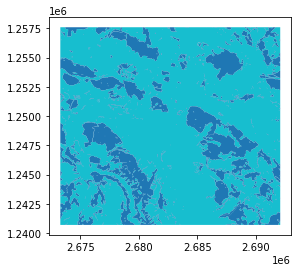

In [104]:
# hierfür braucht ihr das modul "descartes"
wald.plot(column = "Wald_text")

<AxesSubplot:>

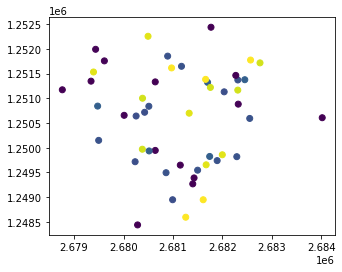

In [106]:
monte_carlo_df.plot(column = "ID")

## Übung 1: Wald oder nicht Wald?

Als erstes stellt sich die Frage, welche Punkte sich innerhalb eines Wald-Polygons befinden. In GIS Terminologie handelt es sich hier um einen *Spatial Join*.

*Spatial Join* ist als Funktion im Modul `geopandas` mit dem namen `sjoin` vorhanden. Wie auf [der Hilfeseite](https://geopandas.org/reference/geopandas.sjoin.html) beschrieben, müssen wir dieser *Function* zwei *GeoDataFrames* übergeben, die ge-joined werden sollen. Es können weitere, optionale Parameter angepasst werden, doch bei uns passen die Default werte.

Führe `gpd.sjoin()` auf die beiden Datensätze `monte_carlo_df` und `wald` aus. Beachte, das die Reihenfolge, mit welchen du die beiden GeoDataFrames der Funktion übergibst eine Rolle spielt. Versuche beide Varianten und wähle die korrekte aus. Stelle dir dazu die Frage: Was für ein Geometrietyp (Punkt / Linie / Polygon) soll der Output haben? Speichere den Output als `mote_carlo_sjoin`. 
Hinweis: Allenfalls müssen das Koordinatensystem der beiden GeoDataFrames nochmals explizit gesetzt werden (z.B. mit `wald.set_crs(epsg = 2056,allow_override = True)`) 


In [107]:


monte_carlo_sjoin = gpd.sjoin(monte_carlo_df,wald)

monte_carlo_sjoin.head()

,ID,x,y,Run_Nr,geometry,index_right,Wald,Shape_Leng,Shape_Area,Wald_text
0,2550,2.679342e+06,1.251346e+06,0,POINT (2679342.334 1251346.270),0,0,947316.853401,2.380876e+08,nein
1,10437,2.681741e+06,1.249824e+06,0,POINT (2681740.565 1249824.010),0,0,947316.853401,2.380876e+08,nein
2,9174,2.681497e+06,1.249546e+06,0,POINT (2681497.002 1249546.406),0,0,947316.853401,2.380876e+08,nein
3,8773,2.682034e+06,1.251131e+06,0,POINT (2682033.926 1251130.509),0,0,947316.853401,2.380876e+08,nein
4,2764,2.680012e+06,1.250656e+06,0,POINT (2680011.649 1250655.533),0,0,947316.853401,2.380876e+08,nein


## Übung 2: Anteil der Punkte pro "Gruppe"

Jetzt wirds etwas kniffelig. Um die Anzahl Punkte innerhalb / ausserhalb vom Wald zu zählen, brauchen wir die `groupby` und `size` aus der Pandas Bibliothek. Es würde den Rahmen von diesem Kurs sprengen, euch die Einzelschritte im Detail zu erläutern, deshalb gebe ich euch den fertigen Code den ihr auf euren Datensatz anwenden könnt.

In [138]:
anteile = monte_carlo_sjoin.groupby(["Run_Nr", "Wald_text"]).size().to_frame("Anzahl")
anteile


Anzahl
Run_Nr Wald_text        
0      ja              1
       nein            9
1      nein           10
2      ja              3
       nein            7
3      ja              1
       nein            9
4      ja              2
       nein            8

Wir sehen in der obigen Tabelle für jeden Run (Spalte "Run_Nr") die Anzahl Werte im Wald ("ja") und ausserhalb ("nein"). Beachte 

- das die Summe aus "ja" + "nein" pro Run gleich gross ist, da wir ja immer gleich viele Zeckenstiche pro Run haben.
- das auch alle Zeckenstiche in einer Gruppe landen können (also alle innerhalb oder alle ausserhalb des Waldes)

Im Nächsten Schritt "pivotiere" ich die Tabelle so, dass "ja" und "nein" einzelne Spalten sind.

In [140]:
anteile_pivot = anteile.pivot_table(index = "Run_Nr", columns = "Wald_text", values = "Anzahl", fill_value = 0)
# mit fill_value = 0 spezifiziere ich, dass der Wert "0" sein soll wenn
# in einem Run kein Wert in "ja" oder "nein" vorhanden sind
# (sprich: wenn alle Stiche entweder innerhalb oder ausserhalb
# des Waldes gelandet sind)

anteile_pivot


Wald_text,ja,nein
Run_Nr,,
0,1,9
1,0,10
2,3,7
3,1,9
4,2,8


## Übung 3: Anteil *im Wald* pro Run ermitteln

Berechnet den Anteil im Wald indem du die die Spalte "ja" mit der Summe aus den Spalten "Ja" + "Nein" dividierst. Nutze dafür die Eckigen Klammern (`[`/`]`) sowie die Splatennamen. Speichere den Output als `anteil_ja`.

In [141]:
anteil_ja = anteile_pivot["ja"]/(anteile_pivot["ja"]+anteile_pivot["nein"])

anteil_ja

Run_Nr
0    0.1
1    0.0
2    0.3
3    0.1
4    0.2
dtype: float64

## Übung 3: Mittelwerte Visualisieren

Gratuliere! Wenn du an diesem Punkt angekommen bist hast du eine ganze Monte Carlo Simulation von A bis Z mit Python durchgeführt. Von hier an steht dir der Weg frei für noch komplexere Analysen. Zum Abschluss kannst du die Mittelwerte wir nun auf einfache Weise visualisieren. Versuche dabei die Methods `plot()` und `plot.box()` sowie `plot.hist()`.

<AxesSubplot:xlabel='Run_Nr'>

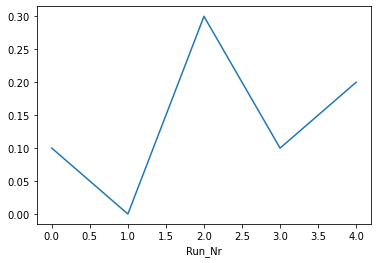

In [142]:
anteil_ja.plot()

<AxesSubplot:>

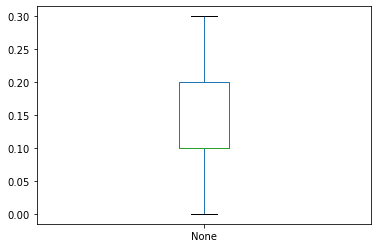

In [136]:
anteil_ja.plot.box()

<AxesSubplot:ylabel='Frequency'>

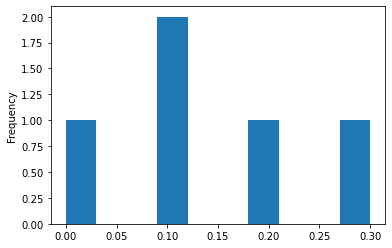

In [137]:
anteil_ja.plot.hist()